In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class NoisePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NoisePredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x_t, t):
        t = t.view(-1, 1).float()
        x = torch.cat([x_t, t], dim=1)
        epsilon_pred = self.fc(x)
        return epsilon_pred.view(x_t.size())


input_dim = 28 * 28  
hidden_dim = 128
T = 1000
batch_size = 64
learning_rate = 1e-3
num_epochs = 10

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [121]:
# Define the variance schedule (beta)
beta = np.linspace(0.0001, 0.02, T)
alpha = 1 - beta
alpha_cumprod = np.cumprod(alpha)
alpha_cumprod_prev = np.concatenate(([1.0], alpha_cumprod[:-1]))


def add_noise(x_0, t, alpha_cumprod):
    noise = torch.randn_like(x_0)
    alpha_cumprod_t = torch.tensor(alpha_cumprod[t], dtype=torch.float32).view(-1, 1)
    mean = torch.sqrt(alpha_cumprod_t) * x_0
    variance = torch.sqrt(1 - alpha_cumprod_t) * noise
    return mean + variance, noise

def reverse_diffusion(model, x_T, T, beta, alpha_cumprod):
    x_t = x_T
    for t in reversed(range(1, T)):
        t_tensor = torch.tensor(t, dtype=torch.long).repeat(x_t.size(0))
        epsilon_pred = model(x_t, t_tensor)
        alpha_t = alpha[t]
        alpha_cumprod_t = alpha_cumprod[t]
        beta_t = beta[t]
        mean = (1 / np.sqrt(alpha_t)) * (x_t - (beta_t / np.sqrt(1 - alpha_cumprod_t)) * epsilon_pred)
        variance = torch.tensor(beta_t)
        noise = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
        x_t = mean + torch.sqrt(variance) * noise
    return x_t


In [90]:
# Instantiate the model, loss function, and optimizer
model = NoisePredictor(input_dim=input_dim, hidden_dim=hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x_0, _ in train_loader:
        x_0 = x_0.view(x_0.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        
        t = torch.randint(1, T, (x_0.size(0),), dtype=torch.long)
        
        x_t, noise = add_noise(x_0, t, alpha_cumprod)
        

        epsilon_pred = model(x_t, t)
        
        loss = criterion(epsilon_pred, noise)
        
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


Epoch [1/10], Loss: 1.0043
Epoch [2/10], Loss: 1.0075
Epoch [3/10], Loss: 1.0044
Epoch [4/10], Loss: 0.9921
Epoch [5/10], Loss: 1.0013
Epoch [6/10], Loss: 0.9818
Epoch [7/10], Loss: 1.0182
Epoch [8/10], Loss: 0.9974
Epoch [9/10], Loss: 1.0065
Epoch [10/10], Loss: 1.0169
Training complete.


# Inference

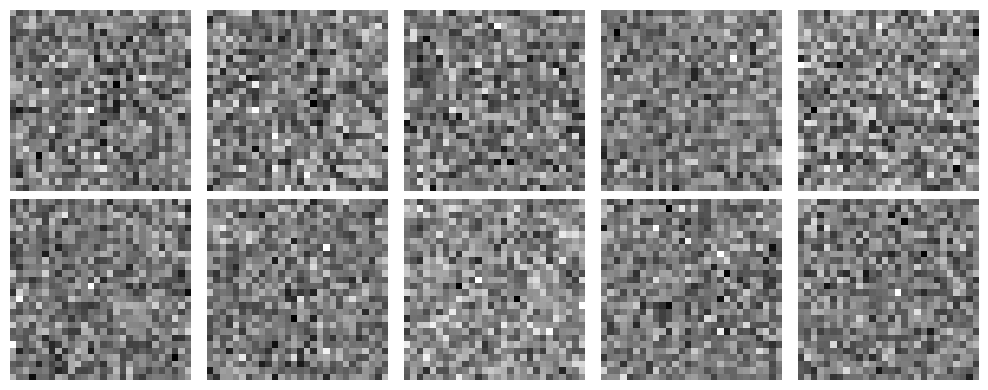

In [125]:
# Inference: Generate images from noise
def generate_images(model, T, beta, alpha_cumprod, num_images=1):
    x_T = torch.randn((num_images, 28, 28)).reshape(num_images,28*28)
    x_0 = reverse_diffusion(model, x_T, T, beta, alpha_cumprod)
    return x_0.reshape(num_images,28,28)

# Generate images
num_images = 10
generated_images = generate_images(model, T, beta, alpha_cumprod, num_images=num_images)

plt.figure(figsize=(10, 4))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(generated_images[i].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
